In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from CHAMP.DataLoader import LoadData, LoadFaceDB
from CHAMP.Monitor import DisplayDico, DisplayConvergenceCHAMP, DisplayConvergenceClassif
from CHAMP.CHAMP_Layer import ConvMP
from CHAMP.DataTools import GenerateGabor, Rebuilt, ContrastNormalized, ChangeBatchSize
import matplotlib.pyplot as plt
from CHAMP.LowLevel import conv
from CHAMP.Classif_Layer import Classif_Layer
import os
home = os.getenv('HOME')
from CHAMP.DataTools import SaveNetwork, LoadNetwork

In [2]:
l0 = 100
nb_dico = 8
dico_size = (5,5)
image_size = (32,32)
OutputL1_size =tuple(image_size[i]-dico_size[i]+1 for i in range(len(dico_size)))
saving_path = 'Records/'

# On CIFAR DataBase

## Load the DataBase

In [3]:
path = "../../../Science/These/Rapport d'avancement/database/CIFARtorch/"
#path = home + "/science/VB_These/Rapport d'avancement/database/Face_DataBase/"
training_set,testing_set = LoadData('CIFAR',data_path=path,avg_size=(5,5),decorrelate=True)

In [4]:
print(testing_set[0].size())

torch.Size([1, 10000, 1, 32, 32])


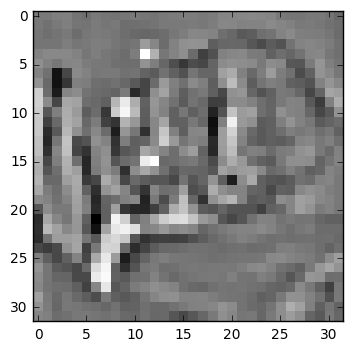

In [5]:
plot = plt.imshow(testing_set[0][0,0,0,:,:].numpy(),cmap='gray')

## Generate Filters

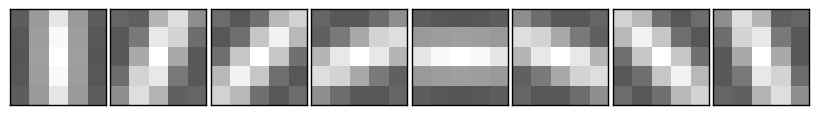

In [6]:
DicoGabor = GenerateGabor(nb_dico=nb_dico,dico_size=dico_size,sigma=1.5,lambd=5,gamma=0.5,psi=0)
DisplayDico(DicoGabor)

## Coding

In [7]:
code_training = ConvMP(image_input=training_set[0][0,:,:,:,:], dictionary=DicoGabor, l0_sparseness=l0,
                modulation=None, verbose=0, train=True, doSym='pos', mask=None,\
                MaskMod='Residual')

In [8]:
reconstructed_image = Rebuilt(training_set[0][0,:,:,:,:],code_training,DicoGabor)

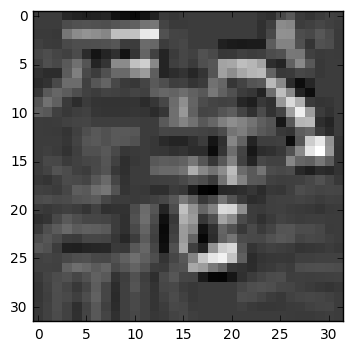

In [9]:
plt.imshow(reconstructed_image[0,0,:,:].numpy(),cmap='gray')

In [10]:
residual=training_set[0][0,:,:,:,:]-reconstructed_image

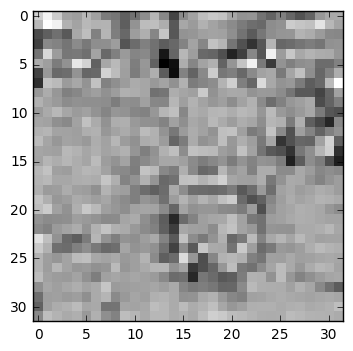

In [11]:
plt.imshow(residual[0,0,:,:].numpy(),cmap='gray')

In [12]:
code_testing = ConvMP(image_input=testing_set[0][0,:,:,:,:], dictionary=DicoGabor, l0_sparseness=l0,
                modulation=None, verbose=0, train=True, doSym='pos', mask=None,\
                MaskMod='Residual')

## Classifying Row Data

In [13]:
SaveExp = False

In [14]:
batch_training_set = ChangeBatchSize(training_set,batch_size=2000)

In [15]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_Raw = Classif_Layer(nb_dico=1,size_image=image_size,nb_categories=10, verbose=0)
    Classifier_Raw = Classifier_Raw.train_classif(batch_training_set,nb_epoch=20000,\
                                                  data_test_loader=testing_set,lr=0.003)
    SaveNetwork(Classifier_Raw, saving_path+'CIFAR_ClassifRaw.pkl')
else : 
    Classifier_Raw = LoadNetwork(saving_path+'CIFAR_ClassifRaw.pkl')

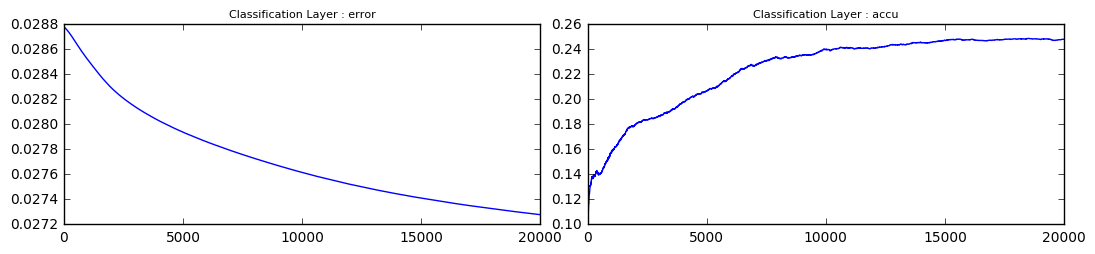

In [16]:
DisplayConvergenceClassif(Classifier_Raw, to_display=['error','accu'])

In [25]:
print('best accuracy : {0}%'.format(Classifier_Raw.accuracy_list[-1]*100))

best accuracy : 24.81%


## Classifying Output of One CHAMP Layer

In [17]:
SaveExp = True

In [18]:
output_Layer1_training = (code_training.to_dense().unsqueeze(0),training_set[1])
output_Layer1_testing = (code_testing.to_dense().unsqueeze(0),testing_set[1])

In [19]:
training_L1_CHAMP = ChangeBatchSize(output_Layer1_training,5000)


In [20]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_CHAMP = Classif_Layer(nb_dico=8,size_image=OutputL1_size,verbose=0,nb_categories=10)
    Classifier_CHAMP = Classifier_CHAMP.train_classif(training_L1_CHAMP,nb_epoch=20000,\
                                   data_test_loader=output_Layer1_testing ,lr=0.003)
    SaveNetwork(Classifier_CHAMP, saving_path+'CIFAR_ClassifCHAMP.pkl')
else : 
    Classifier_CHAMP = LoadNetwork(saving_path+'CIFAR_ClassifCHAMP.pkl')

file saved


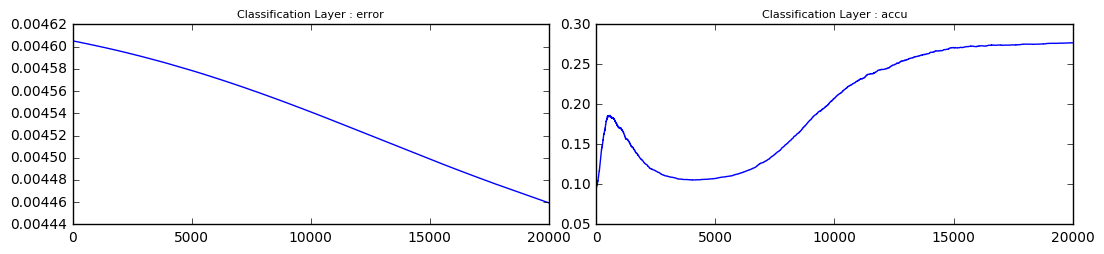

In [21]:
DisplayConvergenceClassif(Classifier_CHAMP, to_display=['error','accu'])

In [27]:
print('best accuracy : {0}%'.format(Classifier_CHAMP.accuracy_list[-1]*100))

best accuracy : 27.700000000000003%


## Classyfing output of Convolutional Layer

In [22]:
SaveExp = True

In [23]:
Output_L1Conv_training = conv(training_set[0][0,:,:,:,:], DicoGabor)
Output_L1Conv_training = (Output_L1Conv_training.unsqueeze(0),training_set[1])
Output_L1Conv_testing = conv(testing_set[0][0,:,:,:,:], DicoGabor)
Output_L1Conv_testing = (Output_L1Conv_testing.unsqueeze(0),testing_set[1])
Output_L1Conv_training  = ChangeBatchSize(Output_L1Conv_training,2000)

In [24]:
from CHAMP.Classif_Layer import Classif_Layer
if SaveExp == True:
    Classifier_CONV = Classif_Layer(nb_dico=8,size_image=OutputL1_size,verbose=0,nb_categories=10)
    Classifier_CONV = Classifier_CONV.train_classif(Output_L1Conv_training,nb_epoch=20000,\
                                                    data_test_loader=Output_L1Conv_testing,lr=0.003)
    SaveNetwork(Classifier_CONV, saving_path+'CIFAR_ClassifCONV.pkl')
else : 
    Classifier_CONV = LoadNetwork(saving_path+'CIFAR_ClassifCONV.pkl'
    

SyntaxError: unexpected EOF while parsing (<ipython-input-24-e17837b92371>, line 8)

In [ ]:
DisplayConvergenceClassif(Classifier_CONV, to_display=['error','accu'])